# 🎮 1D Playground: Diffusion & Flow Matching Sanity Checks

This notebook provides interactive 1D experiments to build intuition for diffusion models and flow matching.

**Why 1D?**
- Ultra-fast training (in seconds & CPU friendly)
- Easy to visualize distributions and flows
- Perfect for debugging and understanding

**Note:** You should be able to use this notebook with CPU only machines.

If you are using VSCode and you do not see your venv in the kernel options, first activate your venv in your terminal and run 

'''

uv run --active python -m ipykernel install --user --name cmu-10799 --display-name "Python (cmu-10799)"

'''

In VS Code:
- Command Palette → Python: Select Interpreter → pick .venv-(your env)/bin/python
- In the notebook → Select Kernel → pick .venv-(your env) or Python (cmu-10799-cpu)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

plt.style.use('default')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Create 1D Mixture of Gaussians

In [2]:
def get_1d_data(name, n_samples=10000):
    """Generate 1D mixture of Gaussians datasets with different weights."""
    if name == '2gaussians':
        # Two Gaussians at -2 and 2 (equal weights)
        centers = [-2.0, 2.0]
        std = 0.3
        weights = [0.5, 0.5]
    elif name == '3gaussians':
        # Three Gaussians at -2, 0, 2 (equal weights)
        centers = [-2.0, 0.0, 2.0]
        std = 0.3
        weights = [1/3, 1/3, 1/3]
    elif name == '5gaussians':
        # Five evenly spaced Gaussians (equal weights)
        centers = [-3.0, -1.5, 0.0, 1.5, 3.0]
        std = 0.25
        weights = [0.2, 0.2, 0.2, 0.2, 0.2]
    elif name == 'uneven':
        # Uneven mixture with different spacing (equal weights)
        centers = [-3.5, -1.0, 0.5, 2.5]
        std = 0.3
        weights = [0.25, 0.25, 0.25, 0.25]
    elif name == 'wide':
        # Wider Gaussians (equal weights)
        centers = [-2.0, 2.0]
        std = 0.8
        weights = [0.5, 0.5]
    elif name == 'weighted2':
        # Two Gaussians with different weights (tall left, short right)
        centers = [-2.0, 2.0]
        std = 0.3
        weights = [0.8, 0.2]
    elif name == 'weighted3':
        # Three Gaussians with different weights (tall-short-medium)
        centers = [-2.5, 0.0, 2.5]
        std = 0.3
        weights = [0.5, 0.2, 0.3]
    elif name == 'weighted5':
        # Five Gaussians with varied weights
        centers = [-3.0, -1.5, 0.0, 1.5, 3.0]
        std = 0.25
        weights = [0.1, 0.15, 0.4, 0.25, 0.1]
    elif name == 'weighted_wide':
        # Wider Gaussians (unequal weights)
        centers = [-2.0, 2.0]
        std = 0.8
        weights = [0.65, 0.35]
    else:
        raise ValueError(f"Unknown dataset: {name}")
    
    # Normalize weights
    weights = np.array(weights)
    weights = weights / weights.sum()
    
    # Sample from each Gaussian according to weights
    X = []
    for center, weight in zip(centers, weights):
        n_samples_for_center = int(n_samples * weight)
        samples = np.random.randn(n_samples_for_center, 1) * std + center
        X.append(samples)
    X = np.concatenate(X, axis=0)
    
    # Shuffle
    np.random.shuffle(X)
    
    return torch.tensor(X, dtype=torch.float32)


def get_ground_truth_density(name, x_values):
    """Compute the ground truth density for a given dataset at x_values."""
    if name == '2gaussians':
        centers = [-2.0, 2.0]
        std = 0.3
        weights = [0.5, 0.5]
    elif name == '3gaussians':
        centers = [-2.0, 0.0, 2.0]
        std = 0.3
        weights = [1/3, 1/3, 1/3]
    elif name == '5gaussians':
        centers = [-3.0, -1.5, 0.0, 1.5, 3.0]
        std = 0.25
        weights = [0.2, 0.2, 0.2, 0.2, 0.2]
    elif name == 'uneven':
        centers = [-3.5, -1.0, 0.5, 2.5]
        std = 0.3
        weights = [0.25, 0.25, 0.25, 0.25]
    elif name == 'wide':
        centers = [-2.0, 2.0]
        std = 0.8
        weights = [0.5, 0.5]
    elif name == 'weighted2':
        centers = [-2.0, 2.0]
        std = 0.3
        weights = [0.8, 0.2]
    elif name == 'weighted3':
        centers = [-2.5, 0.0, 2.5]
        std = 0.3
        weights = [0.5, 0.2, 0.3]
    elif name == 'weighted5':
        centers = [-3.0, -1.5, 0.0, 1.5, 3.0]
        std = 0.25
        weights = [0.1, 0.15, 0.4, 0.25, 0.1]
    elif name == 'weighted_wide':
        centers = [-2.0, 2.0]
        std = 0.8
        weights = [0.65, 0.35]
    else:
        raise ValueError(f"Unknown dataset: {name}")
    
    # Normalize weights
    weights = np.array(weights)
    weights = weights / weights.sum()
    
    # Compute mixture of Gaussians density
    density = np.zeros_like(x_values)
    for center, weight in zip(centers, weights):
        density += weight * (1.0 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_values - center) / std) ** 2)
    
    return density

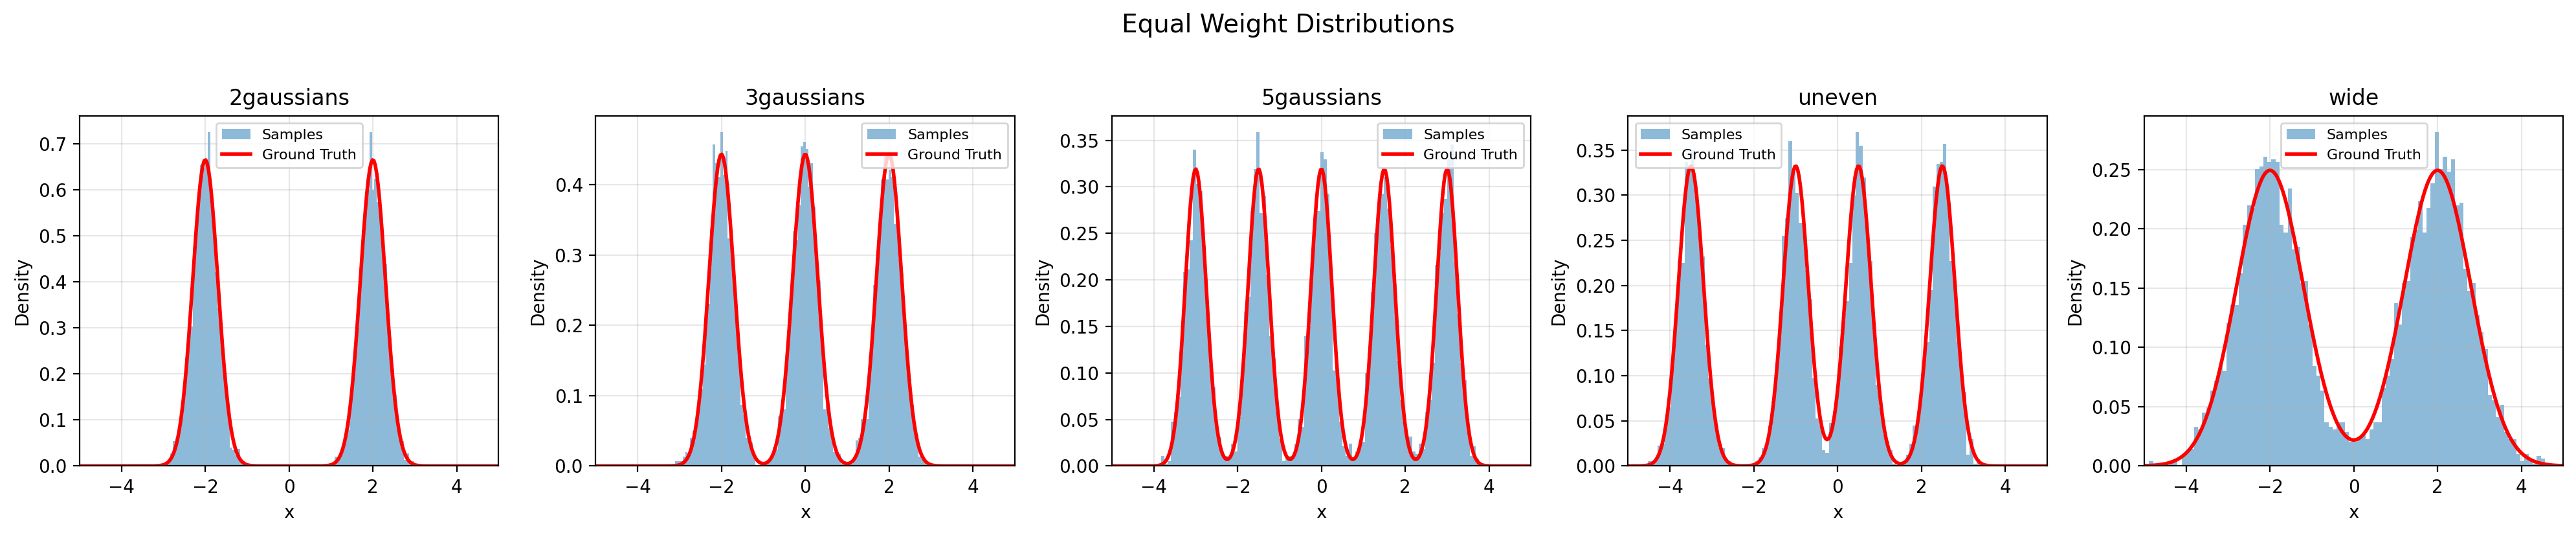

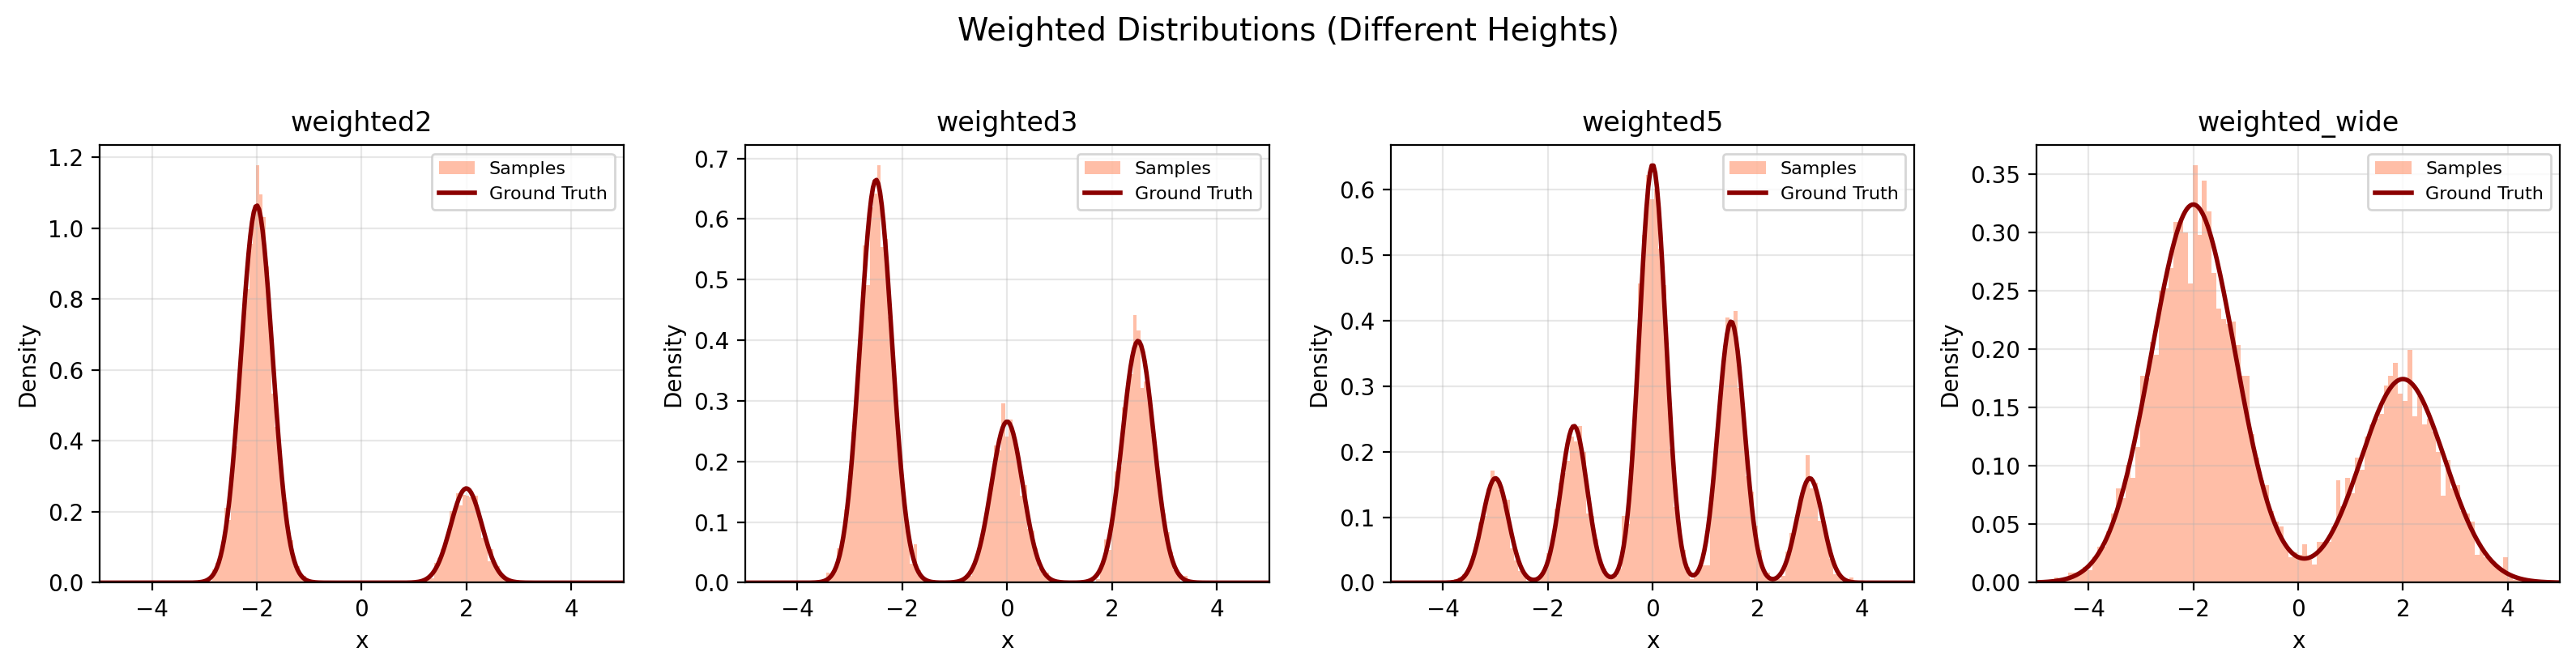

In [3]:
# Visualize available distributions
datasets_equal = ['2gaussians', '3gaussians', '5gaussians', 'uneven', 'wide']
datasets_weighted = ['weighted2', 'weighted3', 'weighted5', 'weighted_wide']

# Plot equal weight distributions
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('Equal Weight Distributions', fontsize=14, y=1.02)
for ax, name in zip(axes, datasets_equal):
    data = get_1d_data(name, n_samples=5000)
    ax.hist(data.numpy(), bins=100, density=True, alpha=0.5, label='Samples')
    
    # Overlay ground truth
    x_line = np.linspace(-5, 5, 300)
    density = get_ground_truth_density(name, x_line)
    ax.plot(x_line, density, 'r-', linewidth=2, label='Ground Truth')
    
    ax.set_title(name)
    ax.set_xlim(-5, 5)
    ax.set_xlabel('x')
    ax.set_ylabel('Density')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

# Plot weighted distributions
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle('Weighted Distributions (Different Heights)', fontsize=14, y=1.02)
for ax, name in zip(axes, datasets_weighted):
    data = get_1d_data(name, n_samples=5000)
    ax.hist(data.numpy(), bins=100, density=True, alpha=0.5, color='coral', label='Samples')
    
    # Overlay ground truth
    x_line = np.linspace(-5, 5, 300)
    density = get_ground_truth_density(name, x_line)
    ax.plot(x_line, density, 'darkred', linewidth=2, label='Ground Truth')
    
    ax.set_title(name)
    ax.set_xlim(-5, 5)
    ax.set_xlabel('x')
    ax.set_ylabel('Density')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

## 2. Simple network for 1D

First design a simple network (like an MLP) to model the 1D data, remember to also include the time embeddings.

In [4]:
## 2. Simple network for 1D
import math
import torch.nn as nn

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class SimpleMLP(nn.Module):
    def __init__(self, hidden_size=128, data_dim=1):
        super().__init__()
        
        # Time embedding layer
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        
        # Main network
        self.input_mlp = nn.Sequential(
            nn.Linear(data_dim, hidden_size),
            nn.ReLU()
        )
        
        self.middle_mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        
        self.output_layer = nn.Linear(hidden_size, data_dim)

    def forward(self, x, t):
        # Embed time
        t_emb = self.time_mlp(t)
        
        # Embed input
        x_emb = self.input_mlp(x)
        
        # Combine (simple addition is standard for diffusion MLPs)
        h = x_emb + t_emb
        
        # Process
        h = self.middle_mlp(h)
        return self.output_layer(h)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_model = SimpleMLP(hidden_size=128).to(device)
print("Model created.")

Model created.


## 3. DDPM algorithm implementation

Implement the forward process, backward process, loss calculation and the sampling process of the DDPM algorithm. You can feel free to follow the structure of src/methods/ddpm.py or directly import your implementation from there.

In [5]:
"""
Denoising Diffusion Probabilistic Models (DDPM)
"""

import math
from typing import Dict, Tuple, Optional, Literal, List

import torch
import torch.nn as nn
import torch.nn.functional as F

from src.methods.base import BaseMethod

class DDPM(BaseMethod):
    def __init__(
        self,
        model: nn.Module,
        device: torch.device,
        num_timesteps: int,
        beta_start: float,
        beta_end: float,
        # TODO: Add your own arguments here
        schedule_type: str = "linear",
    ):
        super().__init__(model, device)

        self.num_timesteps = int(num_timesteps)
        self.beta_start = beta_start
        self.beta_end = beta_end
        # TODO: Implement your own init
        self.schedule_type = schedule_type

        # =========================================================================
        # You can add, delete or modify as many functions as you would like
        # =========================================================================
        
        # Pro tips: If you have a lot of pseudo parameters that you will specify for each
        # model run but will be fixed once you specified them (say in your config),
        # then you can use super().register_buffer(...) for these parameters

        # Pro tips 2: If you need a specific broadcasting for your tensors,
        # it's a good idea to write a general helper function for that

        # 1. Get beta schedule
        if schedule_type == "linear":
            betas = torch.linspace(beta_start, beta_end, num_timesteps, dtype=torch.float32)
        elif schedule_type == "quadratic":
            betas = torch.linspace(beta_start**0.5, beta_end**0.5, num_timesteps, dtype=torch.float32) ** 2
        else:
            raise ValueError(f"Unknown schedule type: {schedule_type}")
        
        # 2. Precompute alphas and other useful terms for sampling and training
        alphas = 1.0 - betas # (T,)
        alphas_cumprod = torch.cumprod(alphas, dim=0) # (T,) (product of alphas from 1 to t)
        # In this line, we compute alpha_t-1 used in posterior q(x_{t-1} | x_t, x_0)'s mean and variance
        # We remove the last element of alphas_cumprod and pad a 1.0 at the beginning
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0) # (T,)
        sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod) # (T,)
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod) # (T,)
        
        # 3. Precompute terms for the reverse process i.e. posterior q(x_{t-1} | x_t, x_0)
        sqrt_reciprocal_alphas = torch.sqrt(1.0 / alphas) # (T,)
        
        # computing posterior variance i.e. beta_tilde for q(x_{t-1} | x_t, x_0) all timesteps
        posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod) # (T,)
        posterior_variance_clamped = torch.max(posterior_variance, torch.tensor(1e-20)) # (T,) # to prevent numerical issues with log(0)
        posterior_log_variance_clipped = torch.log(posterior_variance_clamped) # (T,)
        
        # 4. Register buffers so that they are saved and moved to the correct device automatically
        self.register_buffer("betas", betas)
        self.register_buffer("alphas_cumprod", alphas_cumprod)
        self.register_buffer("alphas_cumprod_prev", alphas_cumprod_prev)
        self.register_buffer("sqrt_alphas_cumprod", sqrt_alphas_cumprod)
        self.register_buffer("sqrt_one_minus_alphas_cumprod", sqrt_one_minus_alphas_cumprod)
        self.register_buffer("sqrt_reciprocal_alphas", sqrt_reciprocal_alphas)
        self.register_buffer("posterior_variance", posterior_variance)
        self.register_buffer("posterior_log_variance_clipped", posterior_log_variance_clipped)
    
    # Helper function to extract value and broadcast it to the shape of x
    def _extract(self, a: torch.Tensor, t: torch.Tensor, x_shape: torch.Size) -> torch.Tensor:
        """
        Helper function to extract values from a 1-D tensor `a` at indices `t` and
        reshape to `x_shape` for broadcasting.
        
        Args:
            a: 1-D tensor of constants (e.g., betas)
            t: 1-D tensor of time indices
            x_shape: Shape of the input tensor (B, C, H, W)
        """
        batch_size = t.shape[0]
        out = a.gather(-1, t.to(a.device))
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
    
    
    # =========================================================================
    # Forward process
    # =========================================================================
    def forward_process(self, x_0: torch.Tensor, t: torch.Tensor, noise: Optional[torch.Tensor] = None) -> torch.Tensor:                
        # TODO: Implement the forward (noise adding) process of DDPM
        # raise NotImplementedError
        """
        Diffuses the data x_0 to time t.
        x_t = sqrt(alpha_bar_t) * x_0 + sqrt(1 - alpha_bar_t) * noise
        """
        if noise is None:
            noise = torch.randn_like(x_0) # Sample noise if not provided # (B, C, H, W)
        
        sqrt_alpha_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_0.shape) # (B, 1, 1, 1) # we get sqrt(alpha_bar_t)
        sqrt_alpha_one_minus_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_0.shape) # (B, 1, 1, 1) # we get sqrt(1 - alpha_bar_t)
        
        return sqrt_alpha_cumprod_t * x_0 + sqrt_alpha_one_minus_cumprod_t * noise
        

    # =========================================================================
    # Training loss
    # =========================================================================
    def compute_loss(self, x_0: torch.Tensor, **kwargs) -> Tuple[torch.Tensor, Dict[str, float]]:
        """
        TODO: Implement your DDPM loss function here
        Computes simple MSE loss between the added noise and the predicted noise by the model.

        Args:
            x_0: Clean data samples of shape (batch_size, channels, height, width) i.e. (B, C, H, W)
            **kwargs: Additional method-specific arguments
        
        Returns:
            loss: Scalar loss tensor for backpropagation
            metrics: Dictionary of metrics for logging (e.g., {'mse': 0.1})
        """
        batch_size = x_0.shape[0]
        
        # 1. Sample random time steps for each sample in the batch
        t = torch.randint(0, self.num_timesteps, (batch_size,), device=x_0.device).long() # (B,)
        
        # 2. Sample random noise from standard normal distribution
        noise = torch.randn_like(x_0) # (B, C, H, W)
        
        # 3. Compute noisy image i.e. x_t using forward process
        x_t = self.forward_process(x_0, t, noise) # (B, C, H, W)
        
        # 4. Predict the noise using the model (which takes x_t and t as input)
        noise_pred = self.model(x_t, t) # (B, C, H, W)
        
        # 5. Compute MSE loss between the true noise and the predicted noise
        loss = F.mse_loss(noise_pred, noise, reduction='mean')
        metrics = {'mse': loss.item()}
        return loss, metrics
        # raise NotImplementedError

    # =========================================================================
    # Reverse process (sampling)
    # =========================================================================
    
    @torch.no_grad()
    def reverse_process(self, x_t: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        TODO: Implement one step of the DDPM reverse process
        # Performs one step of the reverse diffusion process to obtain x_{t-1} from x_t.

        Args:
            x_t: Noisy samples at time t (batch_size, channels, height, width)
            t: the time
            **kwargs: Additional method-specific arguments
        
        Returns:
            x_prev: Noisy samples at time t-1 (batch_size, channels, height, width)
        """
        # raise NotImplementedError
        batch_size = x_t.shape[0]
        
        # 1. Predict the noise using the model at time t
        noise_pred = self.model(x_t, t) # (B, C, H, W)
        
        # 2. Compute the mean of the posterior q(x_{t-1} | x_t, x_0) 
        # mu = 1/sqrt(alpha_t) * (x_t - beta_t / sqrt(1 - alpha_bar_t) * noise_pred)
        sqrt_reciprocal_alpha_t = self._extract(self.sqrt_reciprocal_alphas, t, x_t.shape) # (B, 1, 1, 1)
        betas_t = self._extract(self.betas, t, x_t.shape) # (B, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_t.shape) # (B, 1, 1, 1)
        
        mu = sqrt_reciprocal_alpha_t * (x_t - (betas_t / sqrt_one_minus_alphas_cumprod_t) * noise_pred) # (B, C, H, W)
        
        # 3. Add noise i.e. variance
        # x_{t-1} = mu + sqrt(posterior_variance_t) * z, where z ~ N(0, I)
        # We only add noise if t > 0
        mask = (t > 0).float().view(batch_size, 1, 1, 1) # (B, 1, 1, 1)
        
        # The DDPM paper gives two options for variance:
        # Option 1: Use a fixed variance sigma_t^2 = beta_t
        # Option 2: Use the posterior variance computed during initialization (we use this option here for stability)
        posterior_log_var_t = self._extract(self.posterior_log_variance_clipped, t, x_t.shape) # (B, 1, 1, 1)
        noise = torch.randn_like(x_t) # (B, C, H, W)
        
        # x_{t-1} = mu + sqrt(variance) * z
        x_prev = mu + mask * torch.exp(0.5 * posterior_log_var_t)* noise # (B, C, H, W)
        return x_prev

    @torch.no_grad()
    def sample(
        self,
        batch_size: int,
        image_shape: Tuple[int, int, int],
        verbose: bool = True,
        # TODO: add your arguments here
        **kwargs
    ) -> torch.Tensor:
        """
        TODO: Implement DDPM sampling loop: start from pure noise, iterate through all the time steps using reverse_process()
        Generates samples by running the full reverse process from T to 0

        Args:
            batch_size: Number of samples to generate
            image_shape: Shape of each image (channels, height, width)
            **kwargs: Additional method-specific arguments (e.g., num_steps)
        
        Returns:
            samples: Generated samples of shape (batch_size, *image_shape)
        """
        self.eval_mode()
        # raise NotImplementedError
        device = self.device
        
        # 1. Sample pure noise to start sampling i.e. x_T
        x_t = torch.randn((batch_size, *image_shape), device=device) # (B, C, H, W)
        
        # Store history: [x_T, x_T-1, ..., x_0]
        history = [x_t.cpu()]
        
        # 2. Iteratively apply reverse_process from t = T-1 to t = 0
        iterator = range(self.num_timesteps - 1, -1, -1)
        if verbose:
            from tqdm import tqdm
            iterator = tqdm(iterator, desc="DDPM Sampling", total=self.num_timesteps)
            
        for t in iterator:
            timestep_batch_size = torch.full((batch_size,), t, device=device, dtype=torch.long) # (B,) # create a batch of the same timestep
            x_t_1 = self.reverse_process(x_t, timestep_batch_size) # (B, C, H, W)
            history.append(x_t_1.cpu())
            
            # Update x_t for the next iteration
            x_t = x_t_1
            
        # Return the trajectory of samples
        return history

    # =========================================================================
    # Device / state
    # =========================================================================

    def to(self, device: torch.device) -> "DDPM":
        super().to(device)
        nn.Module.to(self, device)
        self.model = self.model.to(device) 
        self.device = device
        return self

    def state_dict(self) -> Dict:
        state = super().state_dict()
        state["num_timesteps"] = self.num_timesteps
        state["beta_start"] = self.beta_start
        state["beta_end"] = self.beta_end
        # TODO: add other things you want to save
        return state

    @classmethod
    def from_config(cls, model: nn.Module, config: dict, device: torch.device) -> "DDPM":
        ddpm_config = config.get("ddpm", config)
        return cls(
            model=model,
            device=device,
            num_timesteps=ddpm_config["num_timesteps"],
            beta_start=ddpm_config["beta_start"],
            beta_end=ddpm_config["beta_end"],
            # TODO: add your parameters here
        )


## 4. Training

Write your training loop here (or you can combine it above, whichever way is easier for you)

Starting training on cuda...
Iter 0: Loss = 0.9088
Iter 50: Loss = 0.2027
Iter 100: Loss = 0.1890
Iter 150: Loss = 0.1727
Iter 200: Loss = 0.1915
Iter 250: Loss = 0.1891
Iter 300: Loss = 0.1761
Iter 350: Loss = 0.2340
Iter 400: Loss = 0.1809
Iter 450: Loss = 0.1490
Iter 500: Loss = 0.1272
Iter 550: Loss = 0.2525
Iter 600: Loss = 0.1823
Iter 650: Loss = 0.1473
Iter 700: Loss = 0.1816
Iter 750: Loss = 0.1768
Iter 800: Loss = 0.2066
Iter 850: Loss = 0.1640
Iter 900: Loss = 0.1819
Iter 950: Loss = 0.1665
Iter 1000: Loss = 0.1530
Iter 1050: Loss = 0.1345
Iter 1100: Loss = 0.1691
Iter 1150: Loss = 0.1468
Iter 1200: Loss = 0.1490
Iter 1250: Loss = 0.1792
Iter 1300: Loss = 0.1859
Iter 1350: Loss = 0.1674
Iter 1400: Loss = 0.1479
Iter 1450: Loss = 0.1692
Iter 1500: Loss = 0.2397
Iter 1550: Loss = 0.1500
Iter 1600: Loss = 0.1864
Iter 1650: Loss = 0.1173
Iter 1700: Loss = 0.2401
Iter 1750: Loss = 0.2091
Iter 1800: Loss = 0.1509
Iter 1850: Loss = 0.1522
Iter 1900: Loss = 0.2243
Iter 1950: Loss = 0

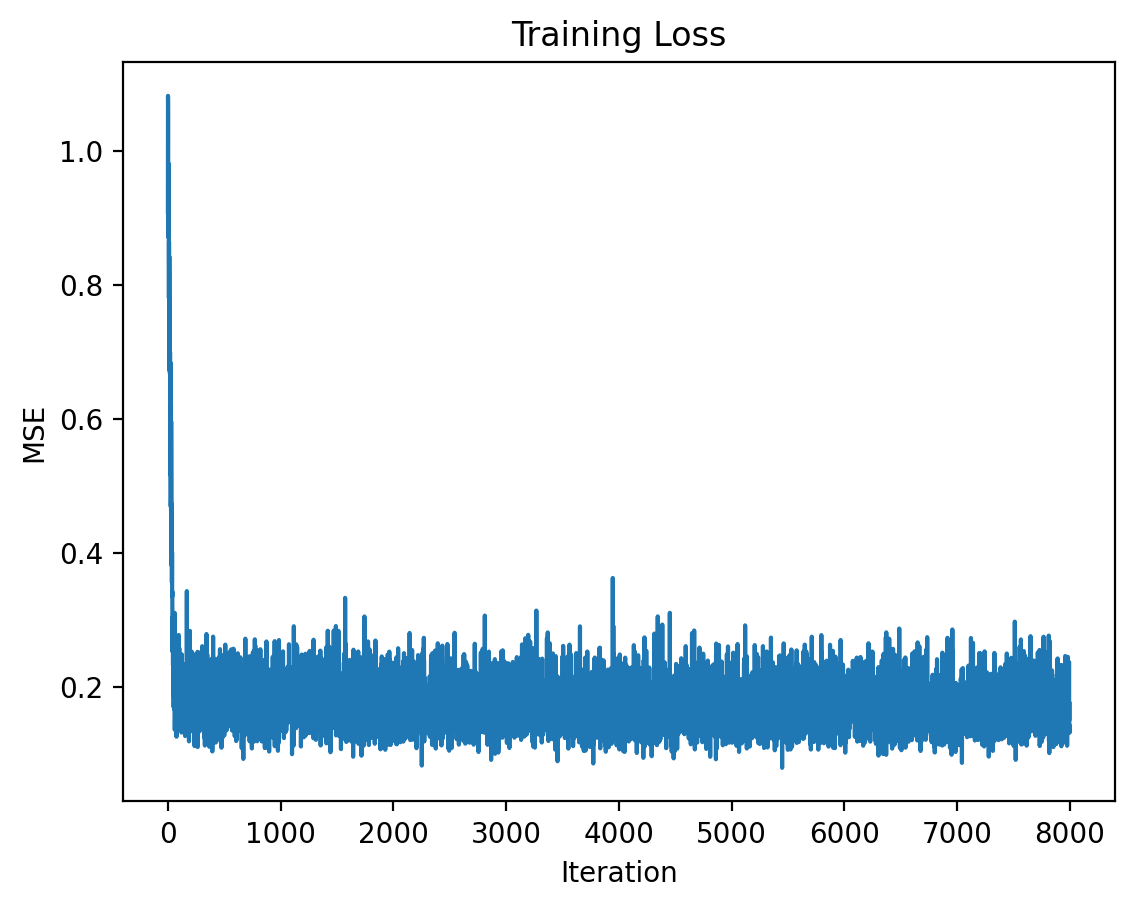

In [6]:
## 4. Training

# === CONFIGURATION ===
# Options: '2gaussians', '3gaussians', '5gaussians', 'uneven', 'wide', etc.
DATASET_NAME = '5gaussians' 
# =====================

# 2. Setup DDPM
ddpm = DDPM(
    model=mlp_model,
    device=device,
    num_timesteps=1000,
    beta_start=0.0001,
    beta_end=0.02
)
ddpm = ddpm.to(device)

# 3. Optimizer
optimizer = torch.optim.Adam(ddpm.parameters(), lr=2e-4)

# 4. Training Loop
num_iterations = 8000
batch_size = 256
logging_interval = 50

print(f"Starting training on {device}...")
loss_history = []

ddpm.train()
for i in range(num_iterations):
    optimizer.zero_grad()
    
    # Get batch
    x_0 = get_1d_data(DATASET_NAME, n_samples=batch_size).to(device)
    
    x_0 = x_0 / 4.0
    
    # Compute Loss
    loss, metrics = ddpm.compute_loss(x_0)
    
    # Backward
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    
    if i % logging_interval == 0:
        print(f"Iter {i}: Loss = {loss.item():.4f}")

print("Training finished.")

# Optional: Plot loss
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.show()

## 5. Visualize Samples

Visualize your learned distributions and compare them with the ground truth. I have left my visualization results for you as reference.

Sampling...


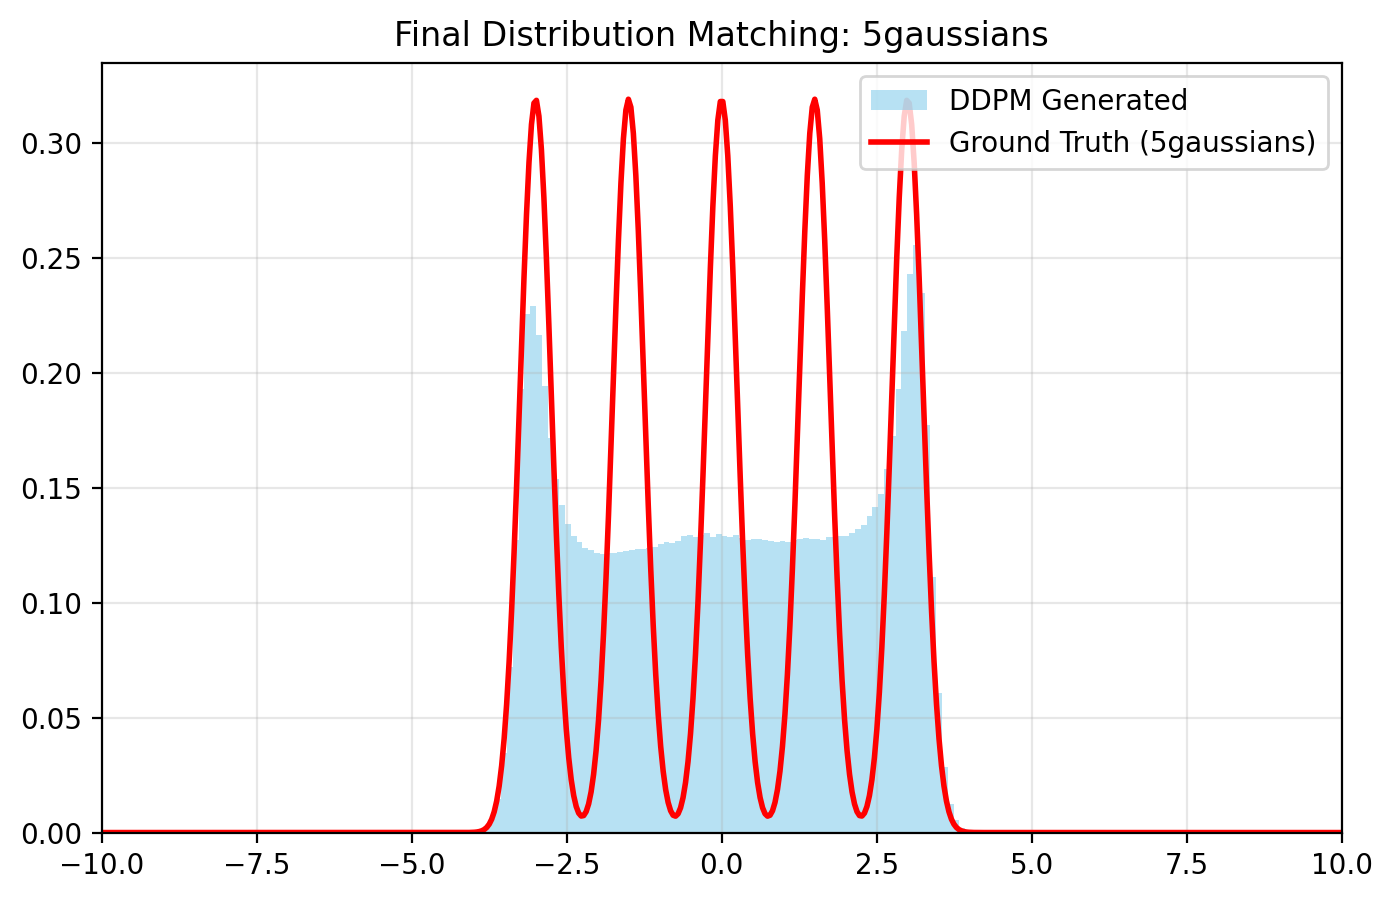

In [7]:
import numpy as np
import matplotlib.pyplot as plt
## 5. Visualize Samples

# 1. Generate Final Samples
print("Sampling...")
# We use the new history method but just take the last element [-1]
trajectory = ddpm.sample(batch_size=2000, image_shape=(1,), verbose=False)
final_samples = trajectory[-1].numpy().flatten()

# 2. Un-normalize to original scale
final_samples = final_samples * 4.0

# 2. Setup Ground Truth Line
x_line = np.linspace(-10, 10, 500)
gt_density = get_ground_truth_density(DATASET_NAME, x_line)

# 3. Plot
plt.figure(figsize=(8, 5))
plt.hist(final_samples, bins=100, density=True, alpha=0.6, color='skyblue', label='DDPM Generated')
plt.plot(x_line, gt_density, 'r-', linewidth=2, label=f'Ground Truth ({DATASET_NAME})')
plt.title(f'Final Distribution Matching: {DATASET_NAME}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(-10, 10)
plt.show()

## 6. Visualize Sampling Trajectories

Besides visualizing the final results, you can also visualize the entire sampling trajectory in order to get a better understanding of the process. Here I also left you my visualization results as an example.

In [8]:
import types

# 1. Define the method that returns the full history
@torch.no_grad()
def sample_with_history(self, batch_size, image_shape, verbose=True):
    self.eval_mode()
    device = self.device
    
    # Start with pure noise
    x = torch.randn((batch_size, *image_shape), device=device)
    
    # Store history: [x_T, x_T-1, ..., x_0]
    history = [x.cpu()]
    
    iterator = range(self.num_timesteps - 1, -1, -1)
    if verbose:
        from tqdm import tqdm
        iterator = tqdm(iterator, desc="Sampling")

    for i in iterator:
        t = torch.full((batch_size,), i, device=device, dtype=torch.long)
        x = self.reverse_process(x, t)
        history.append(x.cpu())
        
    return history

# 2. Bind it to your ddpm instance
ddpm.sample_with_history = types.MethodType(sample_with_history, ddpm)

Generating trajectory...


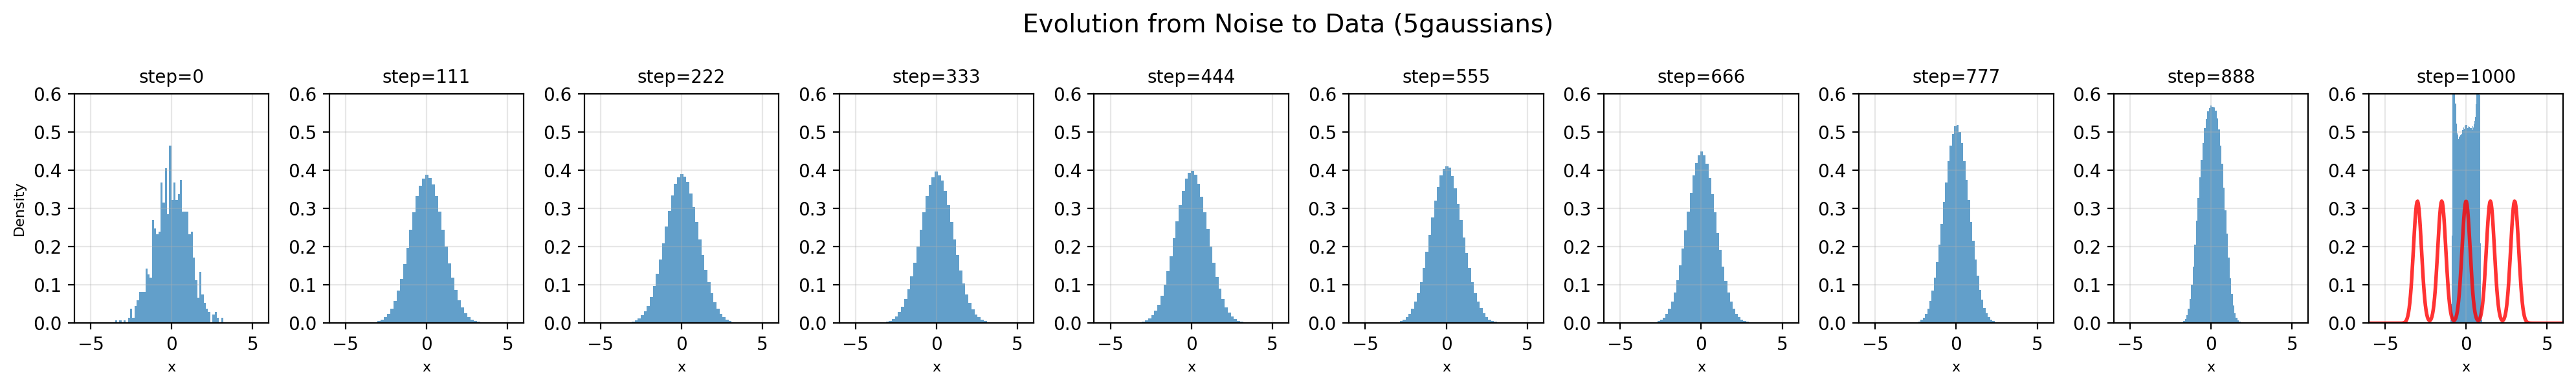

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_trajectory(trajectory, title, n_points=1000, n_steps_show=10, dataset_name=None):
    """Plot sampling trajectory."""
    n_total_steps = len(trajectory)
    
    # Pick time steps to visualize (e.g., t=999, 888, ..., 0)
    step_indices = np.linspace(0, n_total_steps-1, n_steps_show, dtype=int)
    
    fig, axes = plt.subplots(1, n_steps_show, figsize=(2*n_steps_show, 3))
    
    # Prepare ground truth for final step if dataset name provided
    if dataset_name is not None:
        x_line = np.linspace(-6, 6, 300)
        gt_density = get_ground_truth_density(dataset_name, x_line)
    
    for ax, step_idx in zip(axes, step_indices):
        # Get the data at this time step
        # flatten() fixes the "must have 2 or fewer dimensions" error
        points = trajectory[step_idx][:n_points].flatten() 
        
        ax.hist(points.numpy(), bins=50, density=True, alpha=0.7)
        
        # Overlay ground truth on final step (index -1 is the last step, t=0)
        if dataset_name is not None and step_idx == step_indices[-1]:
            ax.plot(x_line, gt_density, 'r-', linewidth=2, alpha=0.8)
        
        ax.set_xlim(-6, 6)
        ax.set_ylim(0, 0.6) # Adjusted scale for better visibility
        ax.set_title(f'step={step_idx}', fontsize=10)
        ax.set_xlabel('x', fontsize=8)
        if ax == axes[0]:
            ax.set_ylabel('Density', fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Run it
print("Generating trajectory...")
# IMPORTANT: Use sample_with_history, not sample!
trajectory = ddpm.sample_with_history(batch_size=1000, image_shape=(1,), verbose=False)

plot_trajectory(trajectory, f"Evolution from Noise to Data ({DATASET_NAME})", n_steps_show=10, dataset_name=DATASET_NAME)